# Baker yeast experiment with 4 parameters - version 0

**Open an interactive online Jupyter Notebook with this content on Binder:**

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gl/ingar-pub%2Fbiolab/master?filepath=%2Fbiolab%2Fby4%2Fpyro_v0.ipynb)

Pyro SVI implementation of experiment simulation.

First, we start with importing modules.

In [15]:
sys.path.append('../../')
from scipy.integrate import solve_ivp
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.distributions.constraints as constraints
import math
import pyro
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO
import pyro.distributions as dist
from scipy.stats import norm
from biolab.bior_util import beta_to_normal

## Model definition

The considered model has 2 states, 2 control inputs and 4 parameters.

In [16]:
# Definiciones
# x[0]: concentración de biomasa, g/l. Valor referencia: 1 - 10 g/l.
# x[1]: concentración de glucosa, g/l. Valor referencia: 0.1 g/l.
# u[0]: factor de dilución h-1. Valor de referencia: 0.05 - 0.20 h-10.
# u[1]: concentracion de sustrato en alimentación g/l. valor de referencia 5 - 35 g/l
# theta[i]: parametros del modelo.
# t: vector con valores de tiempo
class TheModel:
    @staticmethod
    def model_definition(t, x, theta, u):
        x1 = x[0]
        x2 = x[1]
        r = theta[0] * x2 / (theta[1] + x2)
        dx1dt = (r - u[0] - theta[3]) * x1
        dx2dt = -r * x1 / theta[2] + u[0] * (u[1] - x2)
        return [dx1dt, dx2dt]

    # ejecucion del modelo
    def execute(self, x0, t, theta, u):
        return solve_ivp(self.model_definition, t_span=t, y0=x0, args=(theta, u), dense_output=True)

## SVI

SVI implemented in pyro

In [17]:
class TheSvi:
    def __init__(self, model=None, dt=None, prior=None):
        pyro.clear_param_store()

        # obtiene referencias al modelo del bioreactor
        self.model_exp = model
        self.dt = dt

        # define los hiperparametros de la distribucion a priori (en este caso el mismo para todos los theta)
        self.alpha_prior = prior[0]
        self.beta_prior = prior[1]

        # variables con distribucion actual (inicializa con la dist a priori)
        self.alpha0 = prior[0]
        self.beta0 = prior[1]

    # funcion que actualiza la distribucion de cada parametro
    def set_distribution_params(self, alpha, beta):
        self.alpha0 = alpha
        self.beta0 = beta
        return self

    # funcion para obtener una observacion (ejecuta el modelo del bioreactor)
    def get_observation(self, x, u, theta):
        sol = self.model_exp.execute(x, [self.dt[0], self.dt[-1]], theta, u)
        return sol.y[0][-1]

    def model(self, data):
        # samplea theta[i] de la dist a priori
        theta0 = pyro.sample("theta0", dist.Beta(self.alpha0[0], self.beta0[0]))
        theta1 = pyro.sample("theta1", dist.Beta(self.alpha0[1], self.beta0[1]))
        theta2 = pyro.sample("theta2", dist.Beta(self.alpha0[2], self.beta0[2]))
        theta3 = pyro.sample("theta3", dist.Beta(self.alpha0[3], self.beta0[3]))
        theta = [theta0, theta1, theta2, theta3]
        # recorre los datos ya vistos y compara error
        # TODO: no se si esta bien usada la observacion
        for i in range(len(data)):
            # observa el punto i usando el modelo
            obs_sample = self.get_observation(x=data[i][0], u=data[i][1], theta=theta)
            # agrega ruido a la salida haciendo una dist Normal con varianza 0.02
            pyro.sample("obs_{}".format(i), dist.Normal(obs_sample, 0.02), obs=data[i][2])

    def guide(self, data):
        # registra los dos parametros variacionales (para cada theta) en pyro, inicializados con el valor a priori
        alpha_q0 = pyro.param("alpha_q0", torch.tensor(self.alpha_prior[0]), constraint=constraints.positive)
        beta_q0 = pyro.param("beta_q0", torch.tensor(self.beta_prior[0]), constraint=constraints.positive)
        pyro.sample("theta0", dist.Beta(alpha_q0, beta_q0))
        alpha_q1 = pyro.param("alpha_q1", torch.tensor(self.alpha_prior[1]), constraint=constraints.positive)
        beta_q1 = pyro.param("beta_q1", torch.tensor(self.beta_prior[1]), constraint=constraints.positive)
        pyro.sample("theta1", dist.Beta(alpha_q1, beta_q1))
        alpha_q2 = pyro.param("alpha_q2", torch.tensor(self.alpha_prior[2]), constraint=constraints.positive)
        beta_q2 = pyro.param("beta_q2", torch.tensor(self.beta_prior[2]), constraint=constraints.positive)
        pyro.sample("theta2", dist.Beta(alpha_q2, beta_q2))
        alpha_q3 = pyro.param("alpha_q3", torch.tensor(self.alpha_prior[3]), constraint=constraints.positive)
        beta_q3 = pyro.param("beta_q3", torch.tensor(self.beta_prior[3]), constraint=constraints.positive)
        pyro.sample("theta3", dist.Beta(alpha_q3, beta_q3))

    def sample(self):
        theta_init0 = pyro.sample("theta_init0", dist.Beta(self.alpha0[0], self.beta0[0]))
        theta_init1 = pyro.sample("theta_init1", dist.Beta(self.alpha0[1], self.beta0[1]))
        theta_init2 = pyro.sample("theta_init2", dist.Beta(self.alpha0[2], self.beta0[2]))
        theta_init3 = pyro.sample("theta_init3", dist.Beta(self.alpha0[3], self.beta0[3]))
        theta_init = [theta_init0, theta_init1, theta_init2, theta_init3]
        return theta_init

    def optimize(self, data, n_steps, lr=0.0005, betas=(0.90, 0.999)):
        # setea optimizador
        optimizer = Adam({"lr": lr, "betas": betas})

        # seta algoritmo de inferencia
        svi = SVI(self.model, self.guide, optimizer, loss=Trace_ELBO())

        # efectua cada paso del gradiente
        for step in range(n_steps):
            svi.step(data)
            if step % 100 == 0:
                print('.', end='')

        # retorna los parametros aprendidos
        alpha_q0 = pyro.param("alpha_q0").item()
        beta_q0 = pyro.param("beta_q0").item()
        alpha_q1 = pyro.param("alpha_q1").item()
        beta_q1 = pyro.param("beta_q1").item()
        alpha_q2 = pyro.param("alpha_q2").item()
        beta_q2 = pyro.param("beta_q2").item()
        alpha_q3 = pyro.param("alpha_q3").item()
        beta_q3 = pyro.param("beta_q3").item()
        alpha_q = np.array([alpha_q0, alpha_q1, alpha_q2, alpha_q3])
        beta_q = np.array([beta_q0, beta_q1, beta_q2, beta_q3])

        return [alpha_q, beta_q]

## Simulation

In [18]:
# inicializa valores para el modelo
x = [[6.0, 0.1]]
dt = np.arange(0, 20, .5)
u = [[0.2, 5.0]]

# instancia el modelo
model = TheModel()

# inicializa valores para el experimento
D = []

# distribucion a priori
# 4 betas con alfa: 10 y beta: 10 para cada parametro
rho = [np.array([10.0, 10.0, 10.0, 10.0]), np.array([10.0, 10.0, 10.0, 10.0])]

# instancia para efectuar la inferencia variacional de los parametros theta
VI = TheSvi(model=model, dt=dt, prior=rho)

# resultados para graficas
y0 = np.array([6.0])
y1 = np.array([0.1])
rhonormal = beta_to_normal(rho)
hist0 = [(rhonormal[0][0], rhonormal[1][0])]
hist1 = [(rhonormal[0][1], rhonormal[1][1])]
hist2 = [(rhonormal[0][2], rhonormal[1][2])]
hist3 = [(rhonormal[0][3], rhonormal[1][3])]

# iteracion por cada step
for t in range(len(dt) - 1):
    print("\n\ndt = {}".format([dt[t], dt[t + 1]]))

    # setea distribucion y samplea theta
    theta = VI.set_distribution_params(rho[0], rho[1]).sample()

    # obtiene el x con mayor probabilidad de reward en la siguiente etapa
    # X_t = DOE.optimization(model, x, theta, D) if t != 1 else x0

    # ejecuta el modelo con los parametros definidos
    sol = model.execute(x[-1], [dt[t], dt[t + 1]], theta, u[-1])
    x.append([sol.y[0][-1], sol.y[1][-1]])

    # guarda datos del experimento realizado ([[x1, x2], [u1, u2], dx1/dt = y])
    D.append([x[-2], u[-1], x[-1][0]])
    y0 = np.append(y0, sol.y[0][-1])
    y1 = np.append(y1, sol.y[1][-1])

    print("theta: {} \nx: {} \ny: {}".format(theta, x[-2], x[-1]))

    # actualiza la distribucion rho de cada parametro theta
    # TODO revisar si 10 steps no es muy poco
    rho = VI.optimize(data=D, n_steps=10)

    rhonormal = beta_to_normal(rho)
    hist0.append((rhonormal[0][0], rhonormal[1][0]))
    hist1.append((rhonormal[0][1], rhonormal[1][1]))
    hist2.append((rhonormal[0][2], rhonormal[1][2]))
    hist3.append((rhonormal[0][3], rhonormal[1][3]))



dt = [0.0, 0.5]
theta: [tensor(0.4457), tensor(0.5489), tensor(0.5482), tensor(0.5654)] 
x: [6.0, 0.1] 
y: [4.280623542503976, 0.17309317010795605]
.

dt = [0.5, 1.0]
theta: [tensor(0.7562), tensor(0.4615), tensor(0.4569), tensor(0.4835)] 
x: [4.280623542503976, 0.17309317010795605] 
y: [3.2566838986019517, 0.09621940852038971]
.

dt = [1.0, 1.5]
theta: [tensor(0.5700), tensor(0.3545), tensor(0.4213), tensor(0.5925)] 
x: [3.2566838986019517, 0.09621940852038971] 
y: [2.3474755987007816, 0.13465181851749775]
.

dt = [1.5, 2.0]
theta: [tensor(0.4043), tensor(0.3687), tensor(0.3008), tensor(0.6425)] 
x: [2.3474755987007816, 0.13465181851749775] 
y: [1.6411570967204332, 0.2065653732214987]
.

dt = [2.0, 2.5]
theta: [tensor(0.3719), tensor(0.7046), tensor(0.5433), tensor(0.4578)] 
x: [1.6411570967204332, 0.2065653732214987] 
y: [1.257310775286802, 0.5071109474598424]
.

dt = [2.5, 3.0]
theta: [tensor(0.5912), tensor(0.4158), tensor(0.3836), tensor(0.4221)] 
x: [1.257310775286802, 0.507110

## Visualization

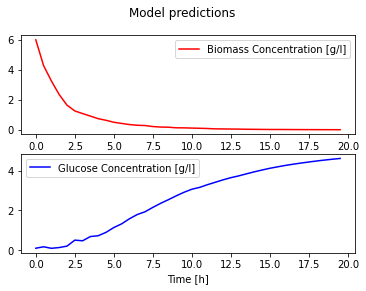

Theta 0 history [(0.5, 0.15811388300841897), (0.47776273491892607, 0.15086056157032293), (0.4790617756286932, 0.15109967975678784), (0.4781729666661002, 0.15094314711965076), (0.4777311964138103, 0.15087554386669796), (0.4783929214322186, 0.15097473637515205), (0.4776929047887009, 0.1508623766498209), (0.4764130227087185, 0.1506827559669255), (0.4753810271751188, 0.1505399497607321), (0.47650465445452117, 0.1507423387431006), (0.4762803502971123, 0.15069169720562947), (0.4757418278299197, 0.15064350825106035), (0.4760479040444527, 0.15072659133096433), (0.4757585742784369, 0.1506829264492065), (0.47505639185527476, 0.15055827322315227), (0.4740523471997882, 0.15044990773866268), (0.47244601273362113, 0.15020444084201207), (0.47190187766879454, 0.15015887003393308), (0.47254546261369407, 0.15028407514216405), (0.47206212654302654, 0.15021451811993647), (0.4724995347449782, 0.15030003888084434), (0.4736548216617858, 0.15049530170020758), (0.4736267104821719, 0.15051678435854368), (0.4741

In [19]:
# grafica resultados
fig, (ax1, ax2) = plt.subplots(2)
fig.suptitle('Model predictions')
ax1.plot(dt, y0, color='r', label='Biomass Concentration [g/l]')
ax1.legend(loc="upper right")
ax2.plot(dt, y1, color='b', label='Glucose Concentration [g/l]')
ax2.legend(loc="upper left")
plt.xlabel("Time [h]")
plt.show()
# grafica theta history
# print("Theta 0 history {}".format(hist0))
# print("Theta 1 history {}".format(hist1))
# print("Theta 2 history {}".format(hist2))
# print("Theta 3 history {}".format(hist3))

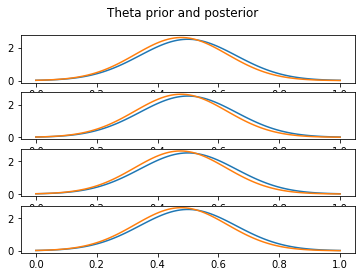

In [20]:
# grafica 1er y última theta_i
# print("Theta evolution {}".format(theta_evo))
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4)
fig.suptitle('Theta prior and posterior')
x = np.linspace(0, 1, 100)
#plt.figure(figsize=(12,6))
#matplotlib.rcParams.update({'font.size': 22})
th0_1 = norm.pdf(x, hist0[0][0], hist0[0][1])
th0_2 = norm.pdf(x, hist0[-1][0], hist0[-1][1])
ax1.plot(x, th0_1)
ax1.plot(x, th0_2)
th1_1 = norm.pdf(x, hist1[0][0], hist1[0][1])
th1_2 = norm.pdf(x, hist1[-1][0], hist1[-1][1])
ax2.plot(x, th1_1)
ax2.plot(x, th1_2)
th2_1 = norm.pdf(x, hist2[0][0], hist2[0][1])
th2_2 = norm.pdf(x, hist2[-1][0], hist2[-1][1])
ax3.plot(x, th2_1)
ax3.plot(x, th2_2)
th3_1 = norm.pdf(x, hist3[0][0], hist3[0][1])
th3_2 = norm.pdf(x, hist3[-1][0], hist3[-1][1])
ax4.plot(x, th3_1)
ax4.plot(x, th3_2)
#plt.legend(["Initial design", "Optimal design"])
#plt.xlabel("$\\theta$")
#plt.ylabel("p.d.f.")
plt.show()